In [50]:
import math
import numpy as np 
from os import mkdir
from numpy.linalg import inv
import csv
import random
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import statistics
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Statistiques : Robot

Nous travaillons sur la base de données diabetes de python. La base initiale comporte
n “ 442 patients et p “ 10 covariables. La variable Y à expliquer est un score correspondant à
l’évolution de la maladie. Pour s’amuser, un robot malicieux a contaminé le jeu de données en
y ajoutant 200 variables explicatives inappropriées. Ensuite, non-content d’avoir déjà perverti
notre jeu de données, il a volontairement mélangé les variables entre elle de façon aléatoire. Bien
entendu le robot a ensuite pris soin d’effacer toute trace de son acte crapuleux si bien que nous
ne connaissons pas les variables pertinentes. La nouvelle base de données comporte n “ 442
patients et p “ 210 covariables, notés X. Saurez-vous déjouer les plans de ce robot farceur et
retrouver les variables pertinentes ?

In [9]:

data = pd.read_csv("data_dm3.csv")

# Le nombre de variables explicatives (covariables) est le nombre de colonnes moins une (la variable cible)
nombre_de_variables_explicatives = data.shape[1] - 1

# Le nombre d'observations est le nombre de lignes
nombre_d_observations = data.shape[0]

# Afficher le nombre de variables explicatives et d'observations
print("Nombre de variables explicatives :", nombre_de_variables_explicatives)
print("Nombre d'observations :", nombre_d_observations)


Nombre de variables explicatives : 210
Nombre d'observations : 441


Moyennes des variables explicatives :
 -3.370019695677726e-05
Écarts-types des variables explicatives :
 0.0018909707686587934


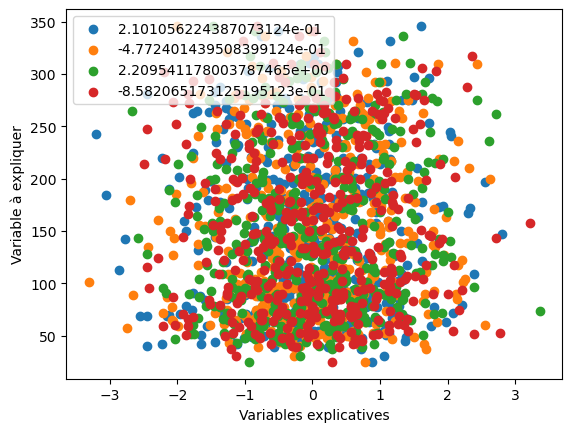

In [21]:
# Séparer les variables explicatives (X) et la variable cible (Y)
X = data.iloc[:, :-1]
Y = data.iloc[:, -1]

# Vérifier si les variables explicatives sont centrées et normalisées
mean_values = X.mean().mean()
std_deviation = X.std().std()


# Afficher les moyennes et écarts-types des variables explicatives
print("Moyennes des variables explicatives :\n", mean_values) #Résultat : moyenne très proche de 0
print("Écarts-types des variables explicatives :\n", std_deviation) #Résultat : Ecart des écart-type très proche de 0 donc écart-type de valeur très proche (de 0)


# Choisir 4 variables explicatives au hasard (vous pouvez personnaliser cette sélection)
variables_aleatoires = np.random.choice(nombre_de_variables_explicatives, 4, replace=False)

# Créer un scatter plot avec les 4 covariables et la variable à expliquer
for variable_index in variables_aleatoires:
    variable_name = X.columns[variable_index]
    plt.scatter(X.iloc[:, variable_index], Y, label=variable_name)

plt.xlabel("Variables explicatives")
plt.ylabel("Variable à expliquer")
plt.legend()
plt.show()


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
print("Taille de l'echantillon d’apprentissage : ",X_train.shape)
print("Taille de l'echantillon de test : ",X_test.shape)

Taille de l'echantillon d’apprentissage :  (330, 210)
Taille de l'echantillon de test :  (111, 210)


/Users/salimatoutraore/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


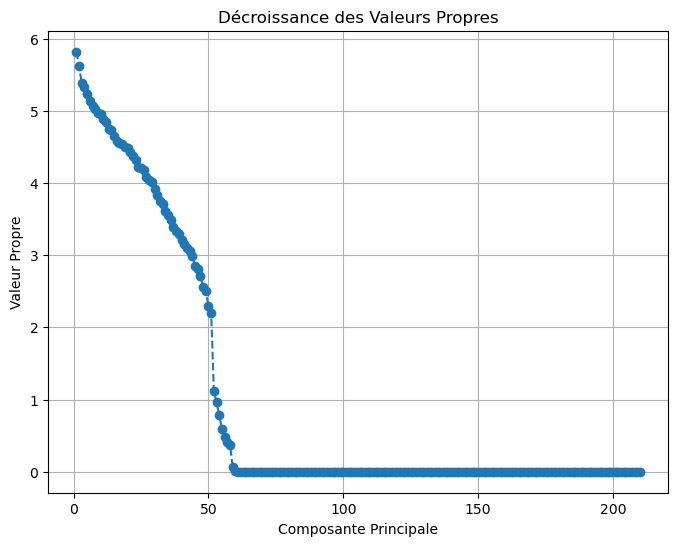

In [29]:
# Calcul de la matrice de covariance
cov_matrix = np.cov(X_train, rowvar=False)

# Calcul des valeurs propres
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Trier les valeurs propres de la plus grande à la plus petite
sorted_eigenvalues = np.sort(eigenvalues)[::-1]

# Tracé de la décroissance des valeurs propres
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues, marker='o', linestyle='--')
plt.xlabel("Composante Principale")
plt.ylabel("Valeur Propre")
plt.title("Décroissance des Valeurs Propres")
plt.grid()
plt.show()

Maintenant, pour expliquer pourquoi il est légitime de ne garder que les premières variables de l'ACP (dans ce cas, k = 10), vous pouvez utiliser le graphique des valeurs propres. Les premières valeurs propres expliquent la plus grande partie de la variance des données. En général, on cherche à conserver suffisamment de composantes principales pour expliquer une proportion élevée (par exemple, 90% ou plus) de la variance totale. Les valeurs propres diminuent rapidement, et au-delà d'un certain point, l'ajout de composantes principales supplémentaires n'apporte pas d'informations significatives.

Le choix de k = 10 semble être basé sur le graphique des valeurs propres. Vous pouvez expliquer que cela permet de conserver une proportion significative de la variance tout en réduisant la dimensionnalité de manière significative, ce qui est avantageux pour la modélisation et la réduction du surajustement

/Users/salimatoutraore/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


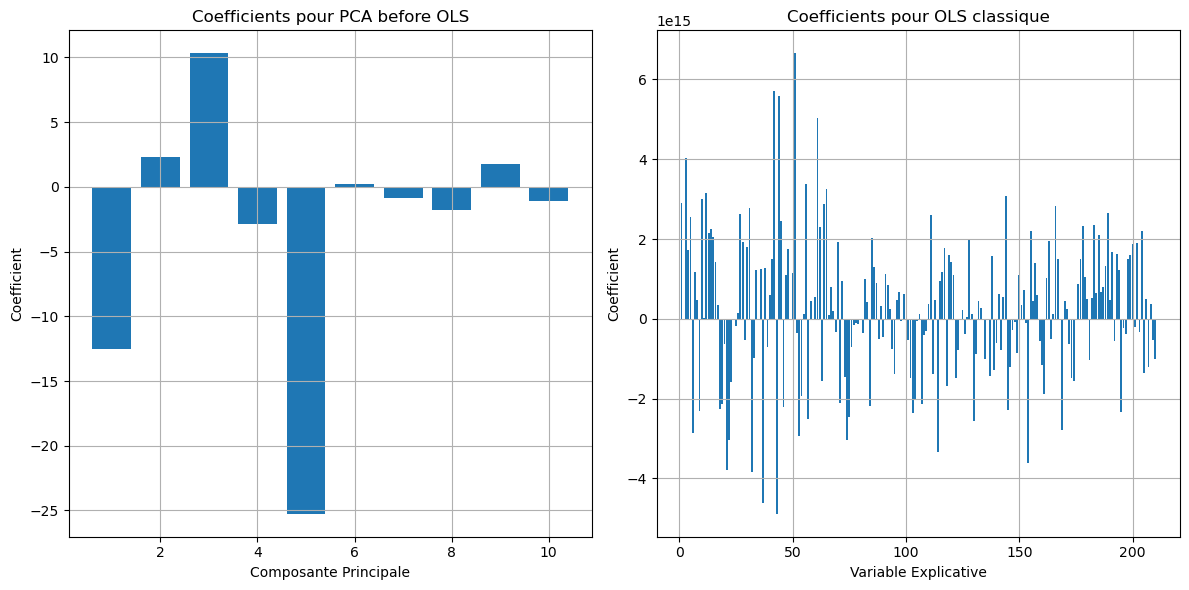

In [39]:
# Sélectionner les 10 premiers vecteurs propres (composantes principales)
k = 10
eigen_vectors = eigenvectors[:, :k]

# Transformer Xtrain en Xtrain_pca
Xtrain_pca = X_train.dot(eigen_vectors).astype(float)

# Régression linéaire (PCA before OLS)
model_pca = LinearRegression(fit_intercept=True)
model_pca.fit(Xtrain_pca, y_train)
coefficients_pca = model_pca.coef_

# Régression linéaire classique (OLS)
model_ols = LinearRegression(fit_intercept=True)
model_ols.fit(X_train, y_train)
coefficients_ols = model_ols.coef_

# Tracé des valeurs des coefficients (hors intercept) pour PCA before OLS
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, k + 1), coefficients_pca)
plt.xlabel("Composante Principale")
plt.ylabel("Coefficient")
plt.title("Coefficients pour PCA before OLS")
plt.grid()

# Tracé des valeurs des coefficients (hors intercept) pour OLS classique
plt.subplot(1, 2, 2)
plt.bar(range(1, X_train.shape[1] + 1), coefficients_ols)
plt.xlabel("Variable Explicative")
plt.ylabel("Coefficient")
plt.title("Coefficients pour OLS classique")
plt.grid()

plt.tight_layout()
plt.show()


In [47]:
# 2. Effectuer l'ACP sur Xtrain en utilisant seulement les 10 premières composantes principales
k = 10
Xtrain_pca = X_train.dot(eigen_vectors[:, :k]).astype(float)

# 3. Centrer et réduire les variables explicatives après l'ACP
scaler = StandardScaler()
Xtrain_pca_scaled = scaler.fit_transform(Xtrain_pca)

# 4. Effectuer une régression linéaire avec les variables explicatives centrées et réduites
model_pca_scaled = LinearRegression(fit_intercept=True)
model_pca_scaled.fit(Xtrain_pca_scaled, y_train)

# 5. Vérifier que l'intercept du modèle est égal à la moyenne de Y sur l'ensemble d'apprentissage
intercept = model_pca_scaled.intercept_

# Calculer la moyenne de Y sur l'ensemble d'apprentissage
moyenne_Y_train = y_train.mean()

# Afficher l'intercept et la moyenne de Y
print("Intercept du modèle PCA après réduction :", intercept)
print("Moyenne de Y sur l'ensemble d'apprentissage :", moyenne_Y_train)

Intercept du modèle PCA après réduction : 152.65454545454546
Moyenne de Y sur l'ensemble d'apprentissage : 152.65454545454546


/Users/salimatoutraore/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


/Users/salimatoutraore/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


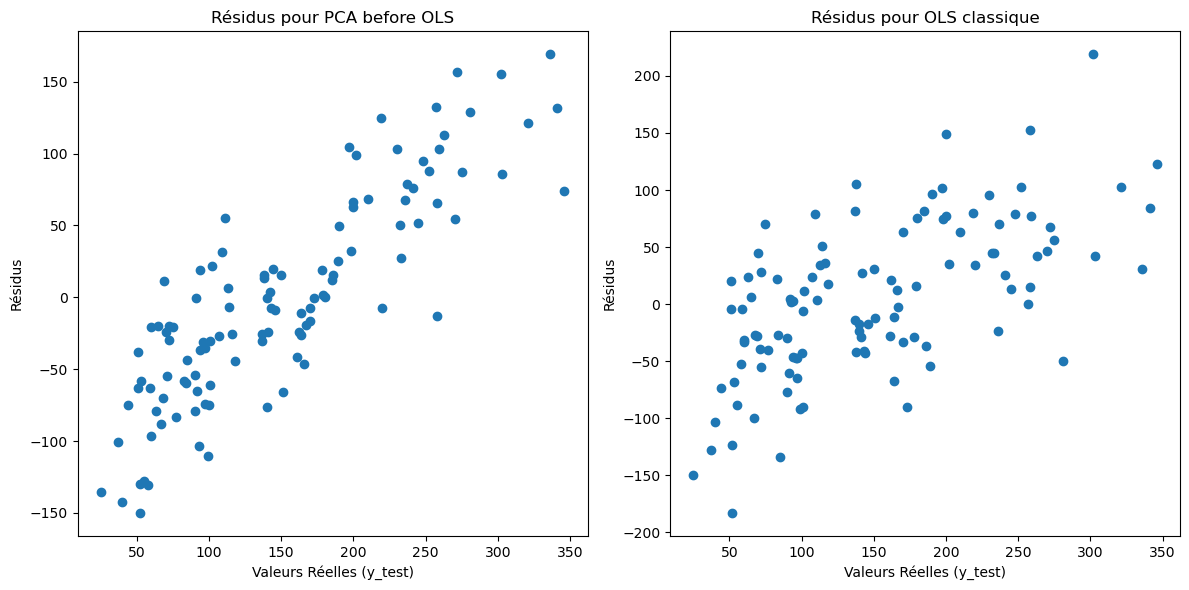

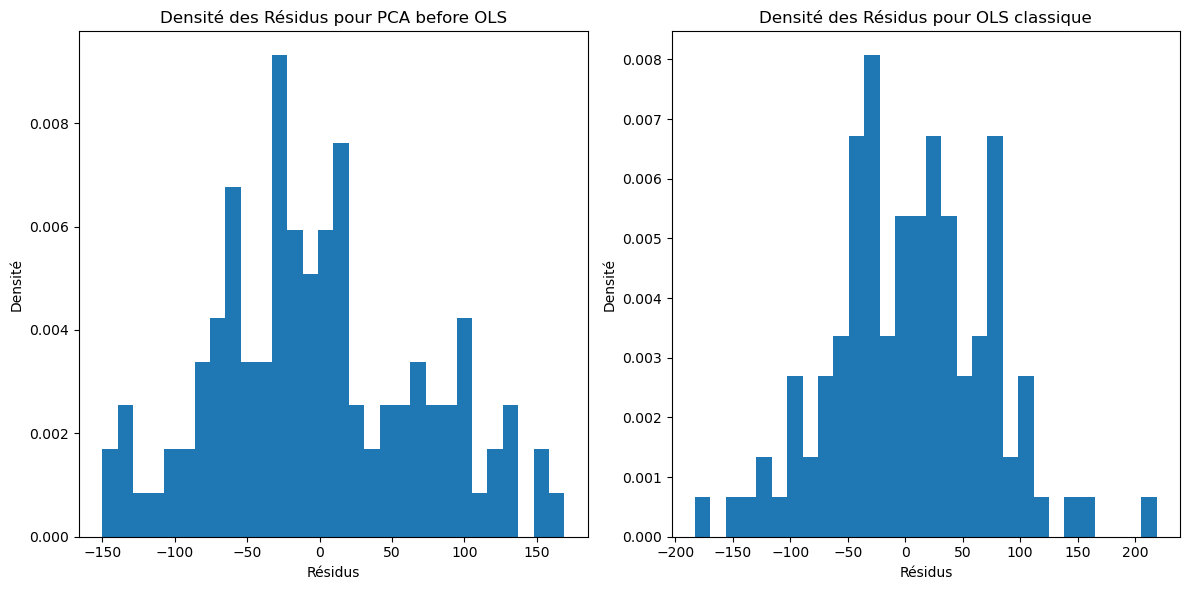

Coefficient de détermination (R²) pour PCA before OLS : 0.1778813825387765
Coefficient de détermination (R²) pour OLS classique : 0.2647458226335472
Risque de prédiction pour PCA before OLS : 5156.155818239313
Risque de prédiction pour OLS classique : 4611.360239255994


In [51]:
# Prédiction avec PCA before OLS
X_test_pca = X_test.dot(eigen_vectors[:, :k]).astype(float)
X_test_pca_scaled = scaler.transform(X_test_pca)
predictions_pca = model_pca_scaled.predict(X_test_pca_scaled)
residus_pca = y_test - predictions_pca

# Prédiction avec OLS classique
predictions_ols = model_ols.predict(X_test)
residus_ols = y_test - predictions_ols

# Tracé des résidus pour PCA before OLS
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, residus_pca)
plt.xlabel("Valeurs Réelles (y_test)")
plt.ylabel("Résidus")
plt.title("Résidus pour PCA before OLS")

# Tracé des résidus pour OLS classique
plt.subplot(1, 2, 2)
plt.scatter(y_test, residus_ols)
plt.xlabel("Valeurs Réelles (y_test)")
plt.ylabel("Résidus")
plt.title("Résidus pour OLS classique")

plt.tight_layout()
plt.show()

# Tracé de la densité des résidus pour PCA before OLS
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(residus_pca, bins=30, density=True)
plt.xlabel("Résidus")
plt.ylabel("Densité")
plt.title("Densité des Résidus pour PCA before OLS")

# Tracé de la densité des résidus pour OLS classique
plt.subplot(1, 2, 2)
plt.hist(residus_ols, bins=30, density=True)
plt.xlabel("Résidus")
plt.ylabel("Densité")
plt.title("Densité des Résidus pour OLS classique")

plt.tight_layout()
plt.show()

# Calcul du R² pour PCA before OLS
r2_pca = r2_score(y_test, predictions_pca)

# Calcul du R² pour OLS classique
r2_ols = r2_score(y_test, predictions_ols)

print("Coefficient de détermination (R²) pour PCA before OLS :", r2_pca)
print("Coefficient de détermination (R²) pour OLS classique :", r2_ols)

# Calcul du risque de prédiction pour PCA before OLS
risque_pca = (1 / len(y_test)) * np.sum((y_test - predictions_pca) ** 2)

# Calcul du risque de prédiction pour OLS classique
risque_ols = (1 / len(y_test)) * np.sum((y_test - predictions_ols) ** 2)

print("Risque de prédiction pour PCA before OLS :", risque_pca)
print("Risque de prédiction pour OLS classique :", risque_ols)


In [ ]:
importance = []
while len()